# Variational Autoencoders
Variational autoencoders (VAE) are a powerful and widely-used class of models to learn complex data distributions in an unsupervised fashion.
Variational autoencoders (VAEs) were defined in 2013 by Kingma et al. and Rezende et al..


* Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 
https://arxiv.org/abs/1312.6114

* Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." arXiv preprint arXiv:1401.4082 (2014)., https://arxiv.org/abs/1401.4082

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/MNIST_data')

Extracting /tmp/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [4]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 16#16#

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2
print('49 * {} // 2 = {}'.format(dec_in_channels,inputs_decoder ))

49 * 1 // 2 = 24


<img src='assets/encoder-decoder.png' width='400px'/>

The encoder compresses data into a latent space ($z$). the decoder reconstructs the data given the hidden representation.


The encoder is a neural network. Its input is a datapoint xx, its output is a hidden representation z, and it has weights and biases $\theta$. To be concrete, let’s say $x$ is a 28 by 28-pixel photo of a handwritten number. The encoder 'encodes' the data which is 784-dimensional into a latent (hidden) representation space $z$, which is much less than 784 dimensions. This is typically referred to as a 'bottleneck' because the encoder must learn an efficient compression of the data into this lower-dimensional space. Let's denote the encoder $q_\theta (z \mid x)$. We note that the lower-dimensional space is stochastic: the encoder outputs parameters to $q_\theta (z \mid x)$, which is a Gaussian probability density. We can sample from this distribution to get noisy values of the representations $z$.

###  Defining the encoder
What's most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

You will see later how we "force" the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the z-values.


In [5]:
from IPython.display import *
display(Latex('$ z = \large \\frac{x - \\mu} {\\sigma }  $'))

<IPython.core.display.Latex object>

We will need the mean and standard deviation of our distributions later, when computing losses.

In [6]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(x.shape) #(?, 7, 7, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        print(x.shape) #(?, 7, 7, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        print(x.shape) #(?, 3136)

        mn = tf.layers.dense(x, units=n_latent) # units: Integer or Long, dimensionality of the output space.
        print(mn.shape) #(?, 8)
        sd = 0.5 * tf.layers.dense(x, units=n_latent) 
        print(sd.shape) #(?, 8)
        print('x :', x.shape)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        print('epsilon :',epsilon.shape) #(?, 8)
        
        # samples of z can be drawn from a simple distibution N(0, I)
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        print(z.shape) #(?, 8)
        return z, mn, sd

In [7]:
print('X_in : ', X_in.shape)
sampled, mn, sd = encoder(X_in, keep_prob)

X_in :  (?, 28, 28)
(?, 14, 14, 64)
(?, 7, 7, 64)
(?, 7, 7, 64)
(?, 3136)
(?, 16)
(?, 16)
x : (?, 3136)
epsilon : (?, 16)
(?, 16)


In [8]:
print(sampled.shape)
print(mn.shape)
print(sd.shape)

(?, 16)
(?, 16)
(?, 16)


### Defining the decoder

<img src='assets/encoder-decoder.png' width='400px'/>

The decoder **does not** care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

The decoder is another neural net. Its input is the representation $z$, it outputs the parameters to the probability distribution of the data, and has weights and biases $\phi$. The decoder is denoted by $p_\phi(x\mid z)$

In [9]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(x.shape) #(?, 24)
        #x = tf.layers.dense(sampled_z, inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        print(x.shape) #(?, 49)
        x = tf.reshape(x, reshaped_dim)
        print(x.shape) #(?, 7, 7, 1)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        
        x = tf.contrib.layers.flatten(x)
        print(x.shape) #(?, 12544)
        
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        print(x.shape) #(?, 784)
        
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Now, we'll wire together both parts:

In [10]:
dec = decoder(sampled, keep_prob)

(?, 24)
(?, 49)
(?, 7, 7, 1)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 12544)
(?, 784)


### Computing losses and enforcing a Gaussian latent distribution
For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the Kullback-Leibler divergence, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs.

In [11]:
unreshaped = tf.reshape(dec, [-1, 28*28])

# reconstruction error, using pixel-wise L2 loss, for each batch
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)

# latent space loss. KL divergence between latent space distribution and unit gaussian, for each batch.
# first half of eq 10. in https://arxiv.org/abs/1312.6114

latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
#kl_loss = -0.5 * tf.reduce_sum(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), axis=1)

loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)


In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Training the network

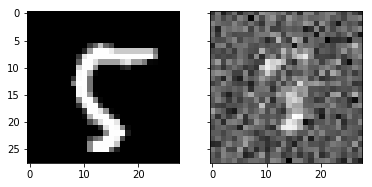

0 176.023 176.01872 0.0042805043 (64, 16) (64, 16)


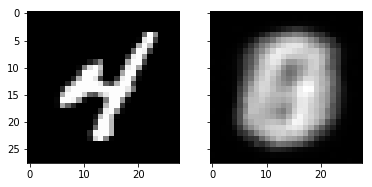

200 49.59003 48.048145 1.5418849 (64, 16) (64, 16)


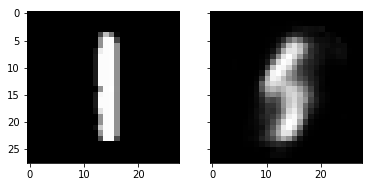

400 45.240738 39.245117 5.9956207 (64, 16) (64, 16)


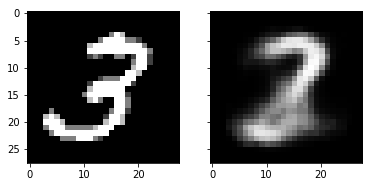

600 36.04592 28.310955 7.734969 (64, 16) (64, 16)


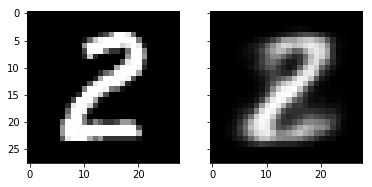

800 36.596344 28.17239 8.423955 (64, 16) (64, 16)


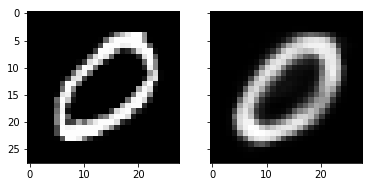

1000 33.773003 25.203596 8.569408 (64, 16) (64, 16)


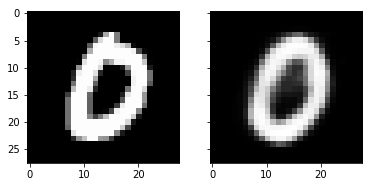

1200 31.647812 23.197826 8.4499855 (64, 16) (64, 16)


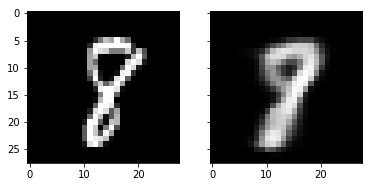

1400 34.607895 25.863785 8.74411 (64, 16) (64, 16)


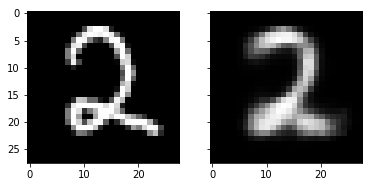

1600 30.669107 21.473484 9.195622 (64, 16) (64, 16)


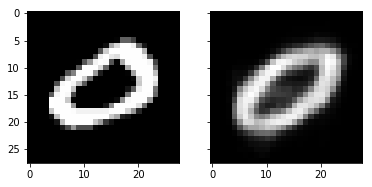

1800 30.103668 21.126041 8.977625 (64, 16) (64, 16)


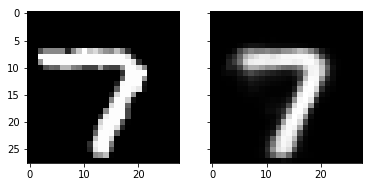

2000 31.577295 22.145834 9.431461 (64, 16) (64, 16)


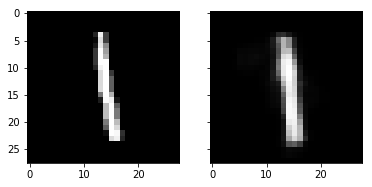

2200 31.585188 22.313812 9.271377 (64, 16) (64, 16)


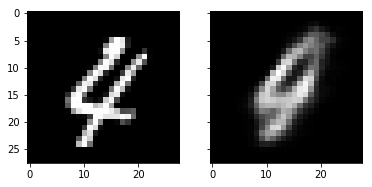

2400 31.378544 21.232235 10.14631 (64, 16) (64, 16)


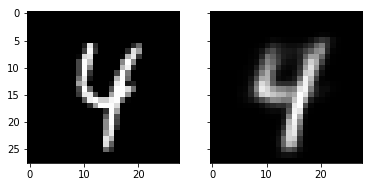

2600 31.267391 20.95581 10.311583 (64, 16) (64, 16)


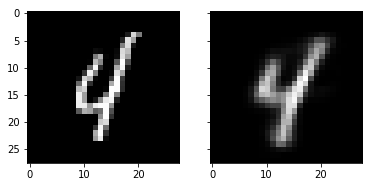

2800 31.232893 21.02433 10.208563 (64, 16) (64, 16)


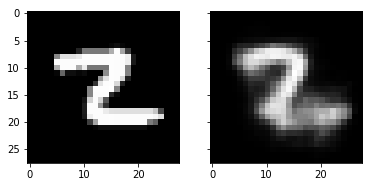

3000 32.578953 22.579718 9.999235 (64, 16) (64, 16)


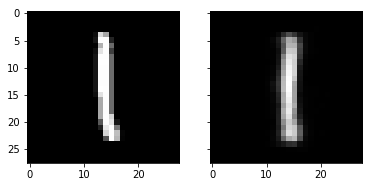

3200 29.53968 19.331684 10.207996 (64, 16) (64, 16)


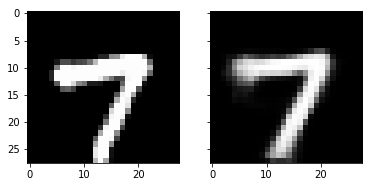

3400 29.975576 20.051863 9.923714 (64, 16) (64, 16)


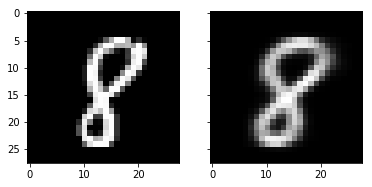

3600 30.412151 19.856922 10.555229 (64, 16) (64, 16)


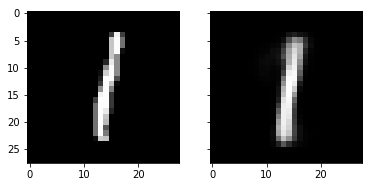

3800 30.794079 20.80422 9.989858 (64, 16) (64, 16)


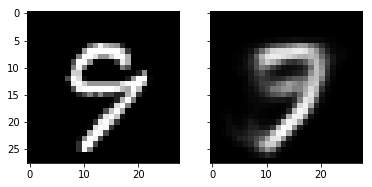

4000 29.909363 19.571915 10.337449 (64, 16) (64, 16)


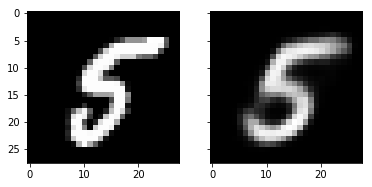

4200 29.810562 19.452185 10.358376 (64, 16) (64, 16)


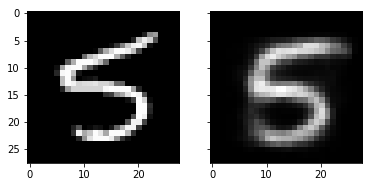

4400 30.901825 19.920223 10.981602 (64, 16) (64, 16)


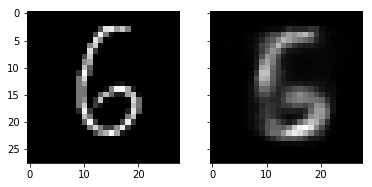

4600 30.06896 19.13047 10.938493 (64, 16) (64, 16)


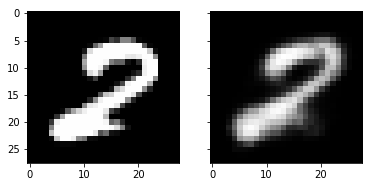

4800 29.742435 19.147781 10.594656 (64, 16) (64, 16)


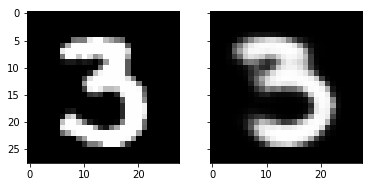

5000 28.974293 18.71859 10.255704 (64, 16) (64, 16)


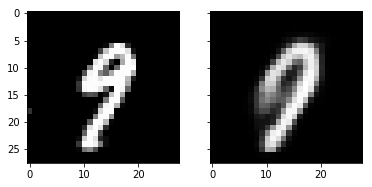

5200 30.47267 19.372662 11.100008 (64, 16) (64, 16)


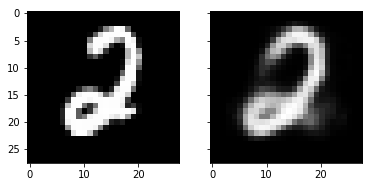

5400 25.590605 15.40336 10.187244 (64, 16) (64, 16)


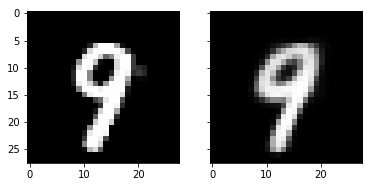

5600 29.223907 18.648651 10.575256 (64, 16) (64, 16)


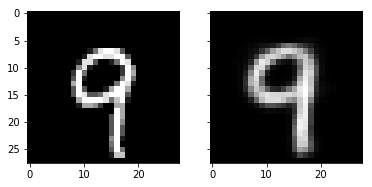

5800 30.296291 19.602268 10.694023 (64, 16) (64, 16)


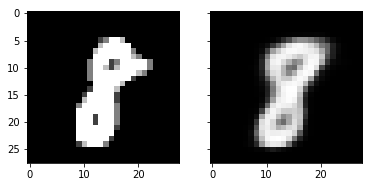

6000 29.775799 18.687227 11.08857 (64, 16) (64, 16)


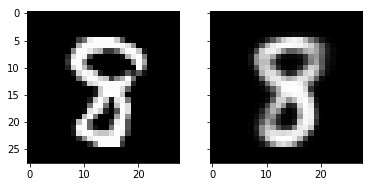

6200 28.565248 17.665455 10.899796 (64, 16) (64, 16)


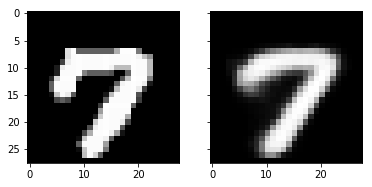

6400 25.729885 15.389443 10.340443 (64, 16) (64, 16)


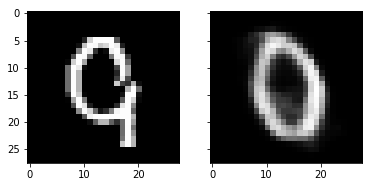

6600 28.756603 17.922892 10.833711 (64, 16) (64, 16)


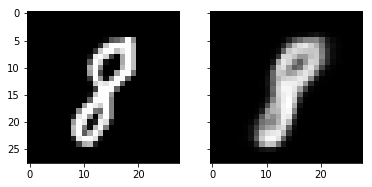

6800 27.357874 16.704788 10.653085 (64, 16) (64, 16)


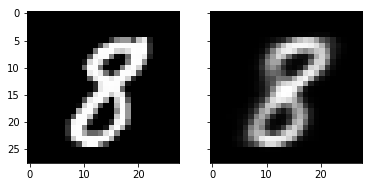

7000 27.689398 17.332527 10.3568735 (64, 16) (64, 16)


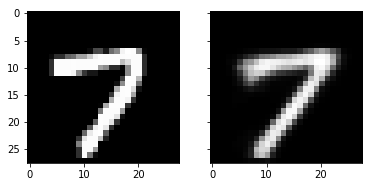

7200 28.964235 18.066013 10.898223 (64, 16) (64, 16)


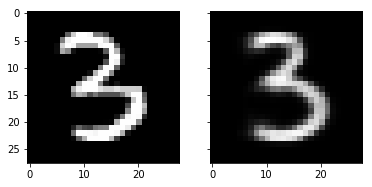

7400 28.58435 17.679842 10.9045105 (64, 16) (64, 16)


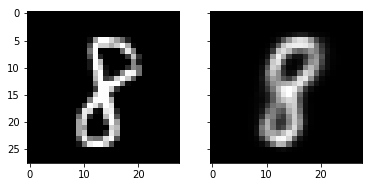

7600 29.954025 19.449066 10.504957 (64, 16) (64, 16)


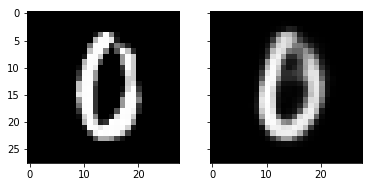

7800 29.714369 18.630283 11.084085 (64, 16) (64, 16)


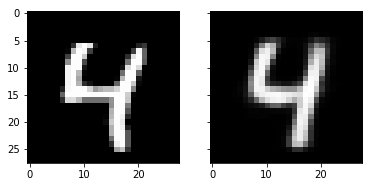

8000 27.173536 15.723348 11.45019 (64, 16) (64, 16)


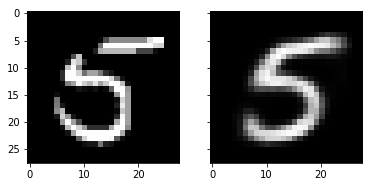

8200 27.165411 15.290889 11.874523 (64, 16) (64, 16)


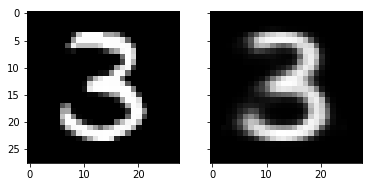

8400 27.865726 16.682873 11.182855 (64, 16) (64, 16)


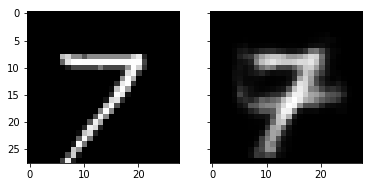

8600 28.620869 17.446102 11.174768 (64, 16) (64, 16)


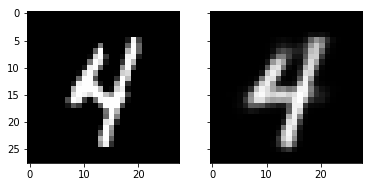

8800 28.489029 17.828617 10.660408 (64, 16) (64, 16)


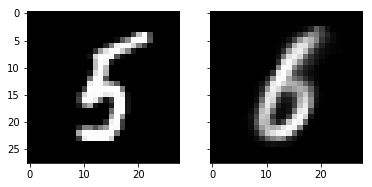

9000 28.101189 16.758835 11.342353 (64, 16) (64, 16)


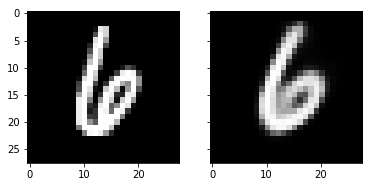

9200 27.235218 16.304016 10.931202 (64, 16) (64, 16)


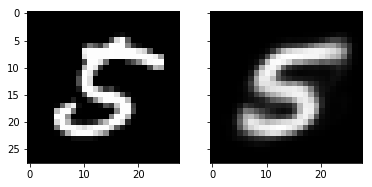

9400 30.243465 19.259434 10.984033 (64, 16) (64, 16)


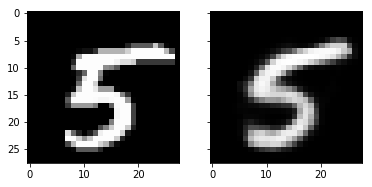

9600 29.616959 18.576054 11.040905 (64, 16) (64, 16)


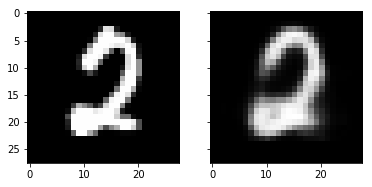

9800 27.635841 16.347271 11.28857 (64, 16) (64, 16)


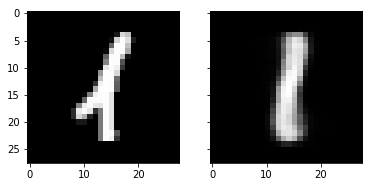

10000 27.669441 17.71899 9.950451 (64, 16) (64, 16)


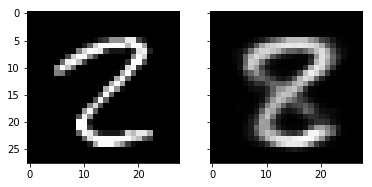

10200 29.186543 17.819815 11.366726 (64, 16) (64, 16)


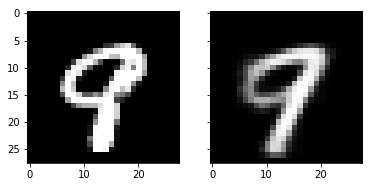

10400 27.337654 16.919117 10.418535 (64, 16) (64, 16)


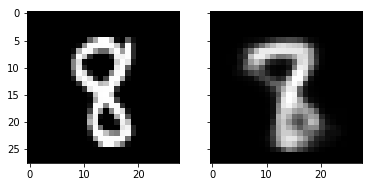

10600 28.48653 17.974371 10.512159 (64, 16) (64, 16)


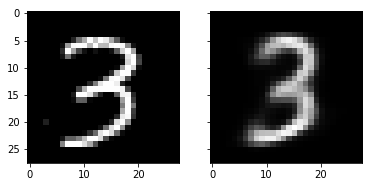

10800 28.064121 16.801468 11.262651 (64, 16) (64, 16)


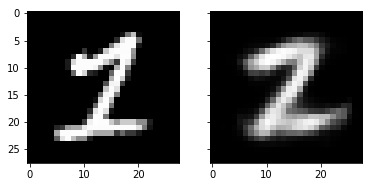

11000 28.603493 17.417355 11.186138 (64, 16) (64, 16)


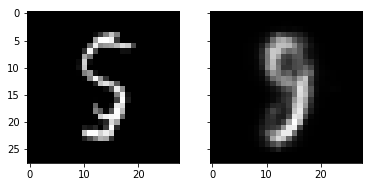

11200 28.05529 16.87891 11.176378 (64, 16) (64, 16)


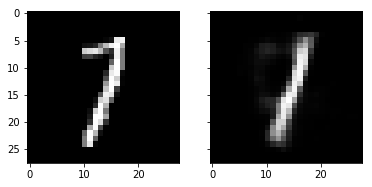

11400 26.192898 15.864527 10.328374 (64, 16) (64, 16)


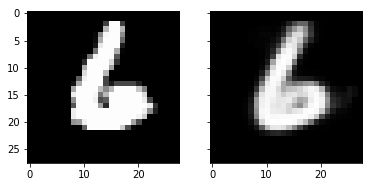

11600 29.501745 17.818811 11.682935 (64, 16) (64, 16)


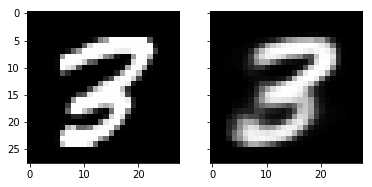

11800 28.775763 17.421223 11.354542 (64, 16) (64, 16)


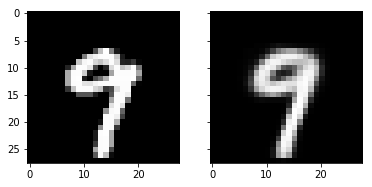

12000 27.90379 16.890121 11.013666 (64, 16) (64, 16)


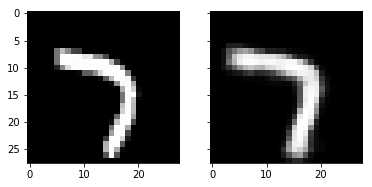

12200 28.562164 17.267258 11.294907 (64, 16) (64, 16)


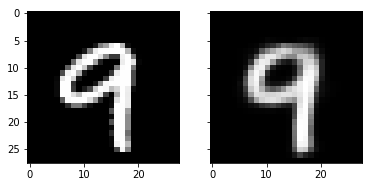

12400 26.021708 14.842096 11.179611 (64, 16) (64, 16)


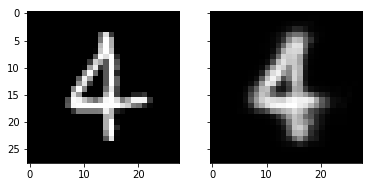

12600 26.465448 15.778244 10.687206 (64, 16) (64, 16)


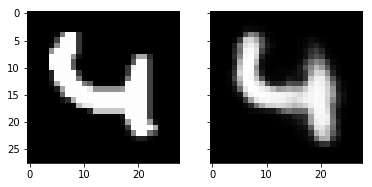

12800 27.88764 16.429798 11.457842 (64, 16) (64, 16)


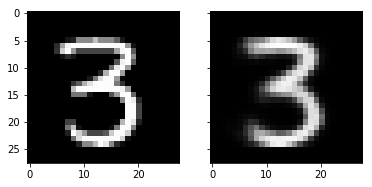

13000 27.65348 16.415443 11.238039 (64, 16) (64, 16)


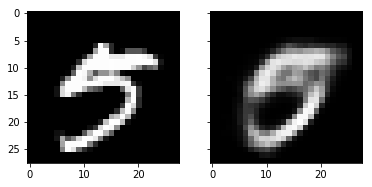

13200 27.64814 16.65723 10.99091 (64, 16) (64, 16)


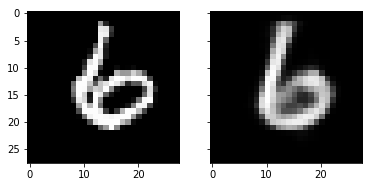

13400 28.692654 17.638134 11.05452 (64, 16) (64, 16)


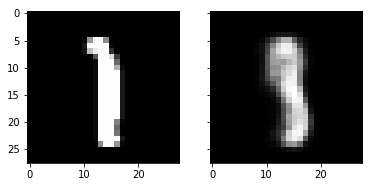

13600 27.425924 16.09811 11.327814 (64, 16) (64, 16)


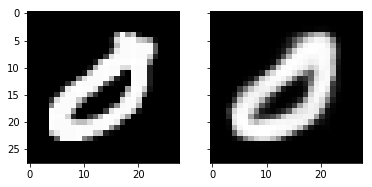

13800 26.739985 15.940997 10.798986 (64, 16) (64, 16)


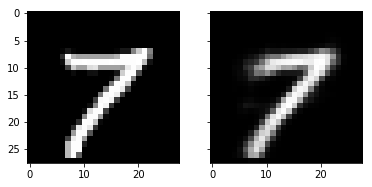

14000 26.84361 15.326077 11.517533 (64, 16) (64, 16)


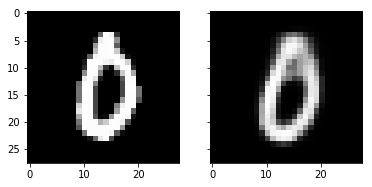

14200 27.105999 16.129272 10.976727 (64, 16) (64, 16)


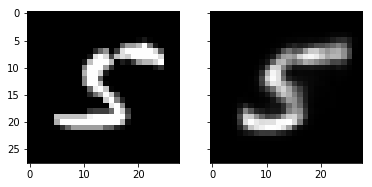

14400 27.725924 16.549778 11.176147 (64, 16) (64, 16)


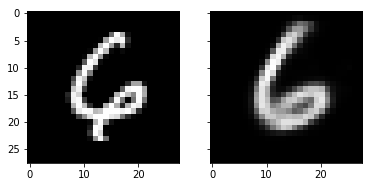

14600 27.624466 16.393387 11.23108 (64, 16) (64, 16)


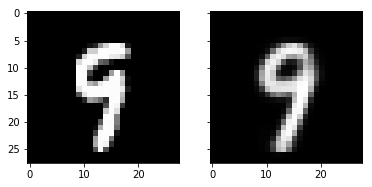

14800 27.630074 16.373455 11.25662 (64, 16) (64, 16)


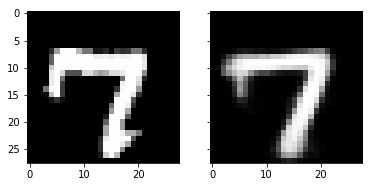

15000 27.609823 16.54317 11.066652 (64, 16) (64, 16)


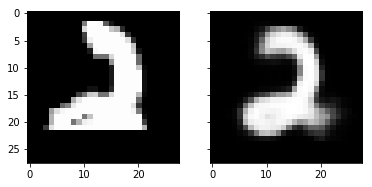

15200 28.881603 17.431095 11.450508 (64, 16) (64, 16)


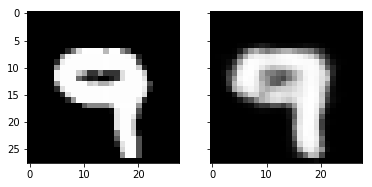

15400 27.125832 15.155277 11.970554 (64, 16) (64, 16)


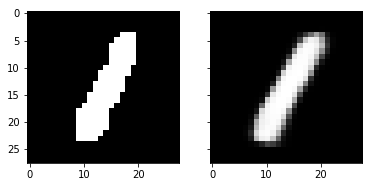

15600 27.331995 16.549236 10.782759 (64, 16) (64, 16)


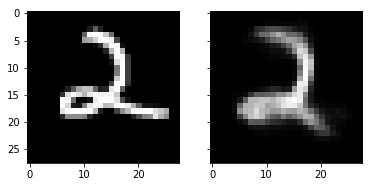

15800 29.73783 18.616175 11.1216545 (64, 16) (64, 16)


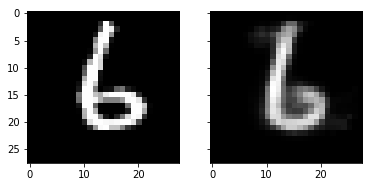

16000 28.02576 16.708817 11.316946 (64, 16) (64, 16)


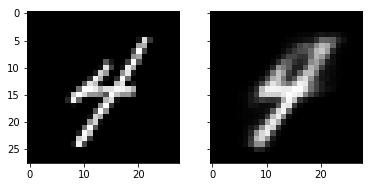

16200 26.802547 15.501122 11.301426 (64, 16) (64, 16)


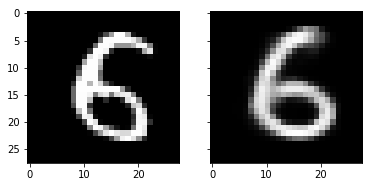

16400 27.583906 16.957703 10.626204 (64, 16) (64, 16)


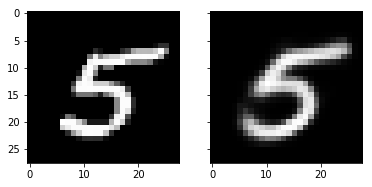

16600 27.100569 15.598357 11.502212 (64, 16) (64, 16)


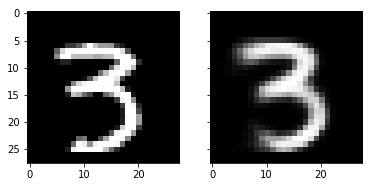

16800 27.087307 15.467449 11.619859 (64, 16) (64, 16)


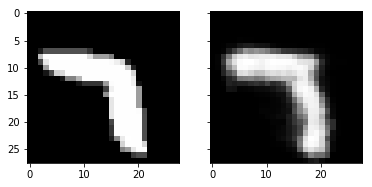

17000 27.401358 15.843489 11.557869 (64, 16) (64, 16)


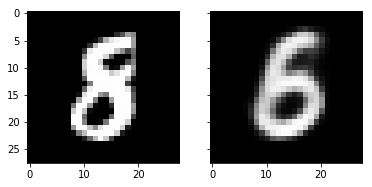

17200 25.169008 14.374754 10.794253 (64, 16) (64, 16)


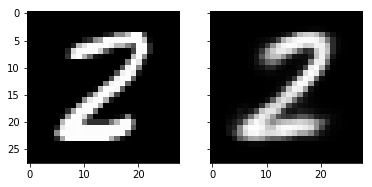

17400 27.440098 15.73584 11.704259 (64, 16) (64, 16)


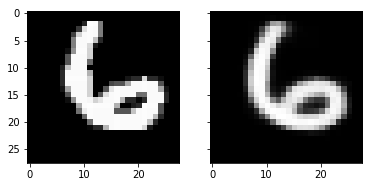

17600 27.424538 16.193974 11.230564 (64, 16) (64, 16)


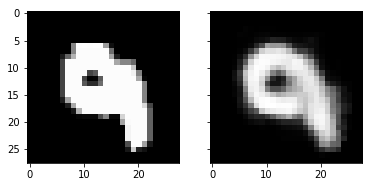

17800 28.788876 17.32436 11.464515 (64, 16) (64, 16)


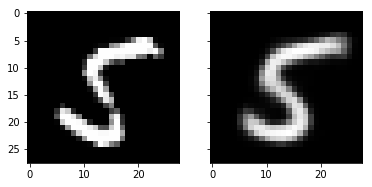

18000 26.374584 15.592295 10.782289 (64, 16) (64, 16)


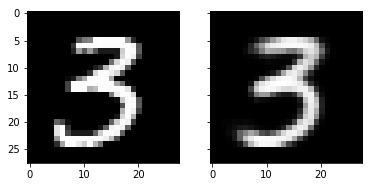

18200 26.029375 14.579817 11.449558 (64, 16) (64, 16)


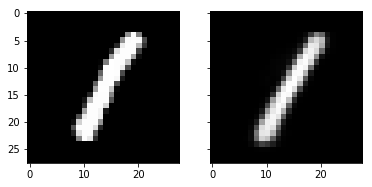

18400 28.122877 16.724508 11.398368 (64, 16) (64, 16)


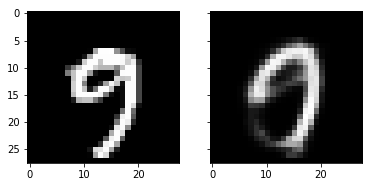

18600 27.871307 16.183224 11.688084 (64, 16) (64, 16)


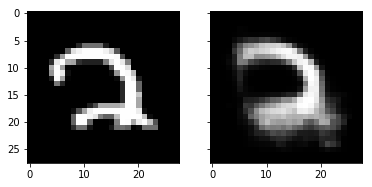

18800 26.519398 15.536843 10.982555 (64, 16) (64, 16)


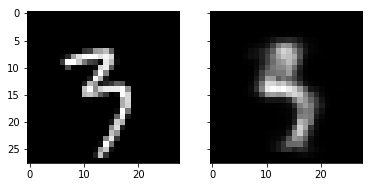

19000 27.314556 16.15017 11.164387 (64, 16) (64, 16)


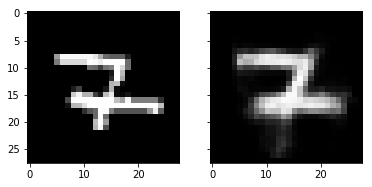

19200 26.865866 15.906626 10.959242 (64, 16) (64, 16)


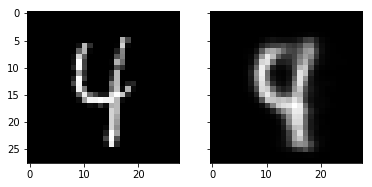

19400 28.016163 16.180605 11.835559 (64, 16) (64, 16)


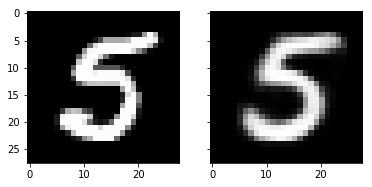

19600 26.964806 14.990072 11.974733 (64, 16) (64, 16)


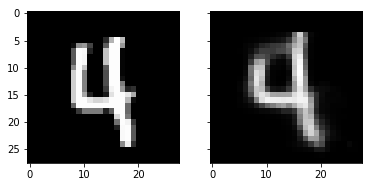

19800 28.47382 16.476868 11.996948 (64, 16) (64, 16)


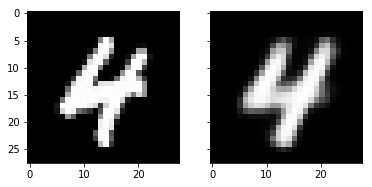

20000 28.498976 16.150114 12.348862 (64, 16) (64, 16)


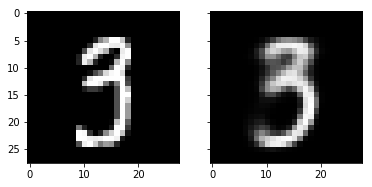

20200 28.203968 16.701351 11.502618 (64, 16) (64, 16)


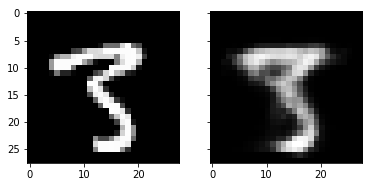

20400 26.880142 15.766184 11.113957 (64, 16) (64, 16)


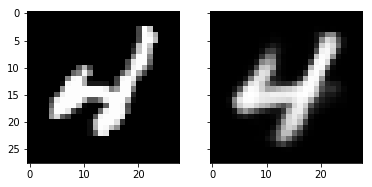

20600 26.01756 14.594242 11.423315 (64, 16) (64, 16)


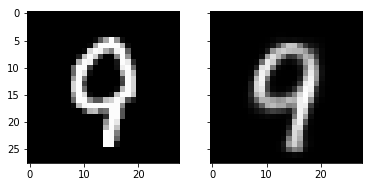

20800 27.055523 15.678582 11.37694 (64, 16) (64, 16)


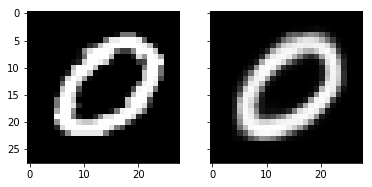

21000 26.802744 15.483952 11.318791 (64, 16) (64, 16)


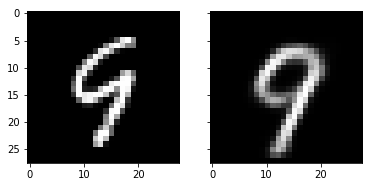

21200 28.285513 16.985086 11.3004265 (64, 16) (64, 16)


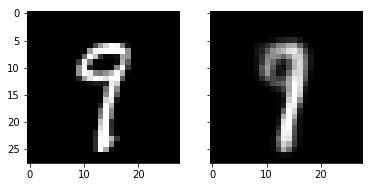

21400 28.76698 17.287981 11.478998 (64, 16) (64, 16)


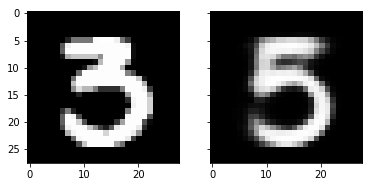

21600 26.450382 15.031916 11.418468 (64, 16) (64, 16)


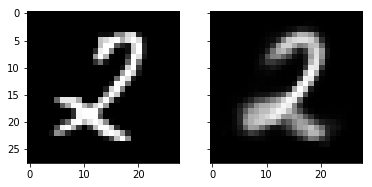

21800 27.170952 15.816849 11.354104 (64, 16) (64, 16)


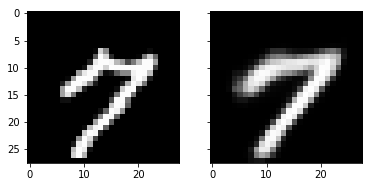

22000 26.643906 15.884287 10.759618 (64, 16) (64, 16)


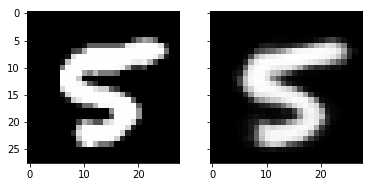

22200 27.558216 15.901615 11.656599 (64, 16) (64, 16)


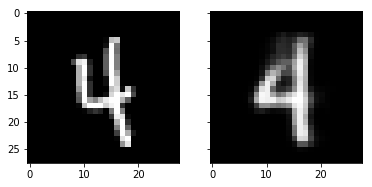

22400 26.335423 14.929167 11.406258 (64, 16) (64, 16)


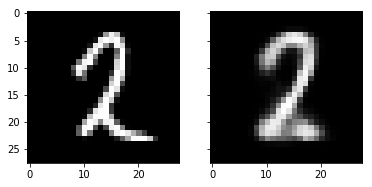

22600 26.72142 15.580123 11.1413 (64, 16) (64, 16)


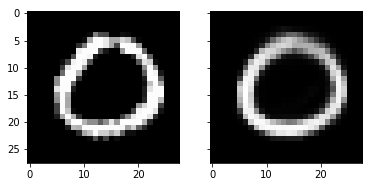

22800 27.298975 15.421936 11.877039 (64, 16) (64, 16)


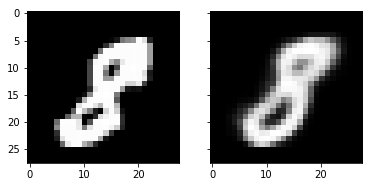

23000 28.515781 16.191452 12.32433 (64, 16) (64, 16)


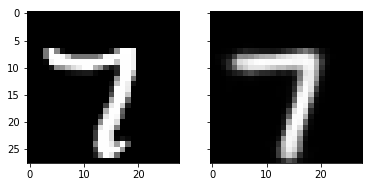

23200 24.45726 13.536497 10.920763 (64, 16) (64, 16)


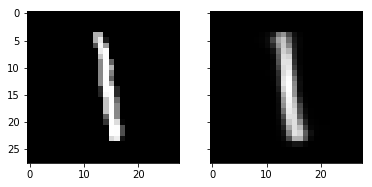

23400 25.52859 13.972128 11.556461 (64, 16) (64, 16)


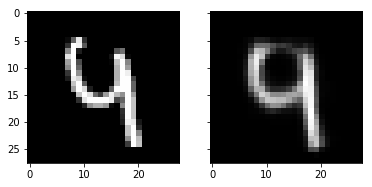

23600 28.025616 16.356503 11.669111 (64, 16) (64, 16)


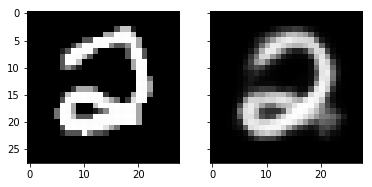

23800 27.336506 15.910124 11.426383 (64, 16) (64, 16)


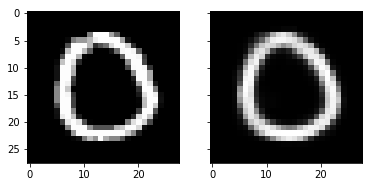

24000 25.56824 14.378159 11.190083 (64, 16) (64, 16)


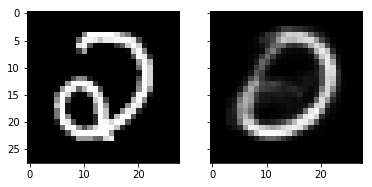

24200 25.245419 14.198424 11.046995 (64, 16) (64, 16)


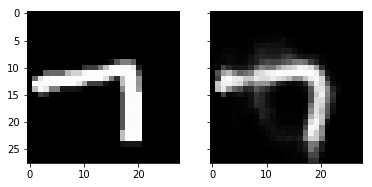

24400 28.201477 16.654215 11.547264 (64, 16) (64, 16)


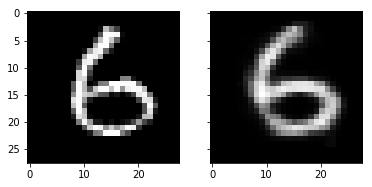

24600 25.906578 14.640738 11.265842 (64, 16) (64, 16)


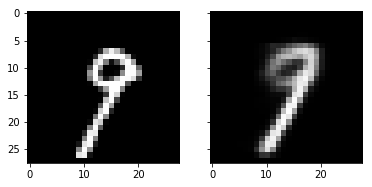

24800 26.178677 14.574886 11.603792 (64, 16) (64, 16)


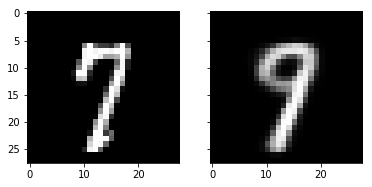

25000 24.743694 13.45901 11.284685 (64, 16) (64, 16)


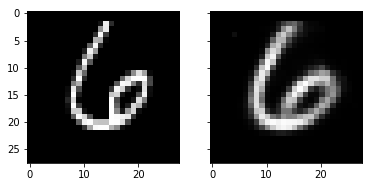

25200 27.188133 15.488979 11.699156 (64, 16) (64, 16)


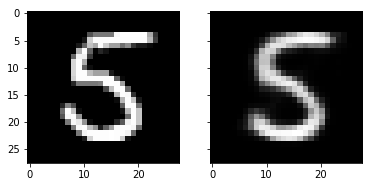

25400 26.562603 15.452589 11.110015 (64, 16) (64, 16)


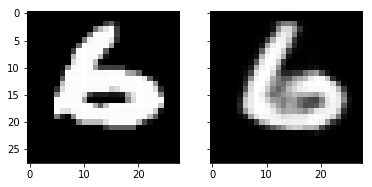

25600 29.072372 16.483728 12.588645 (64, 16) (64, 16)


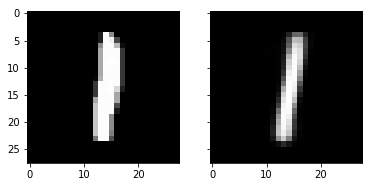

25800 27.908443 15.778612 12.129831 (64, 16) (64, 16)


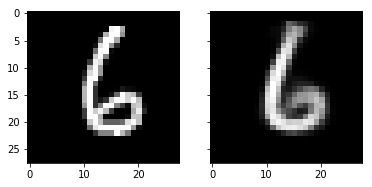

26000 26.161644 14.563971 11.5976715 (64, 16) (64, 16)


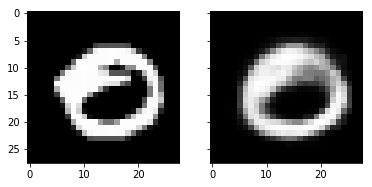

26200 27.368275 15.5047035 11.863571 (64, 16) (64, 16)


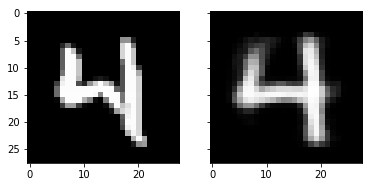

26400 27.592907 15.505175 12.087732 (64, 16) (64, 16)


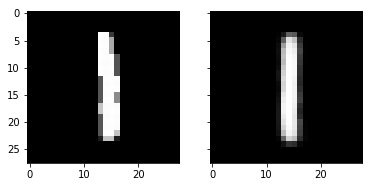

26600 26.197378 14.832076 11.365302 (64, 16) (64, 16)


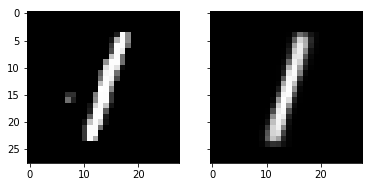

26800 27.701984 16.060215 11.641769 (64, 16) (64, 16)


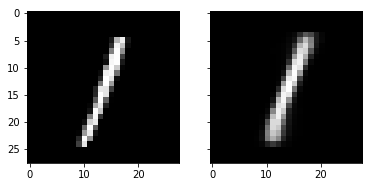

27000 26.636791 15.185469 11.451322 (64, 16) (64, 16)


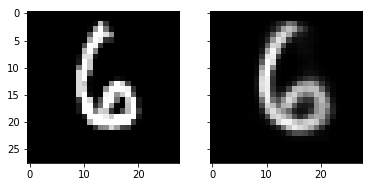

27200 26.032309 14.637676 11.394631 (64, 16) (64, 16)


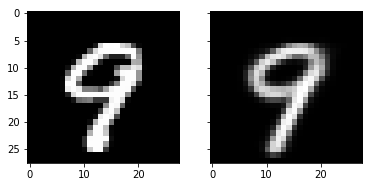

27400 25.749218 14.113815 11.635403 (64, 16) (64, 16)


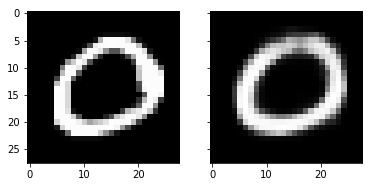

27600 28.13863 16.444231 11.694401 (64, 16) (64, 16)


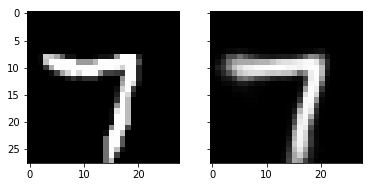

27800 26.647877 15.165081 11.482796 (64, 16) (64, 16)


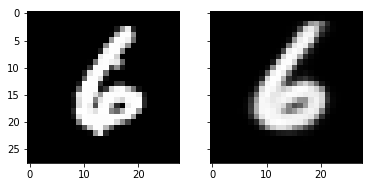

28000 26.26194 14.72091 11.541029 (64, 16) (64, 16)


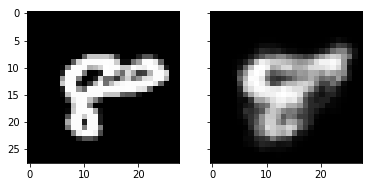

28200 28.165695 15.796496 12.3692 (64, 16) (64, 16)


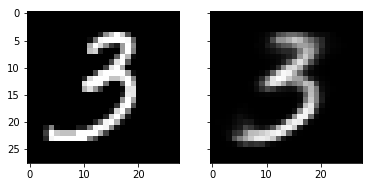

28400 26.34912 14.556301 11.792818 (64, 16) (64, 16)


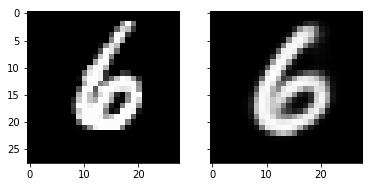

28600 27.27021 15.097776 12.172435 (64, 16) (64, 16)


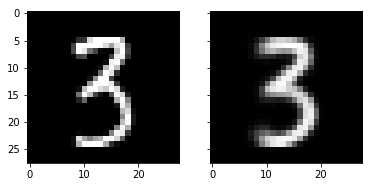

28800 28.062199 16.6281 11.434099 (64, 16) (64, 16)


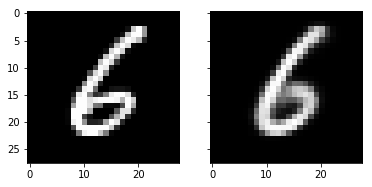

29000 28.871246 16.530699 12.340549 (64, 16) (64, 16)


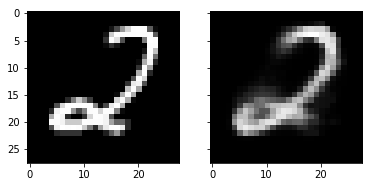

29200 28.905445 17.117968 11.787478 (64, 16) (64, 16)


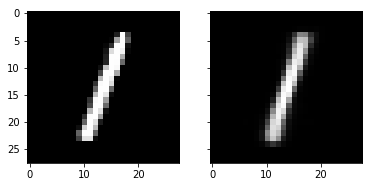

29400 25.268417 14.100756 11.167664 (64, 16) (64, 16)


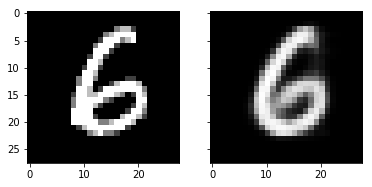

29600 27.46061 15.64464 11.815972 (64, 16) (64, 16)


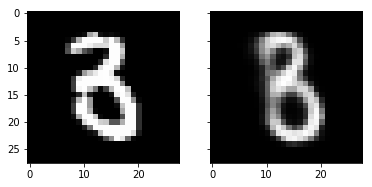

29800 26.212238 14.124711 12.087528 (64, 16) (64, 16)


In [13]:
vloss = []
vll = []

for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    l,ll,  _ = sess.run([loss, latent_loss, optimizer], feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    vloss.append(l)
    vll.append(ll)
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        
        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6,12))
        
        axes[0].imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        #plt.show()
        axes[1].imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls), np.shape(mu), np.shape(sigm))
        

In [14]:
print(np.shape(mu))
print(np.shape(sigm))


(64, 16)
(64, 16)


(30000,)


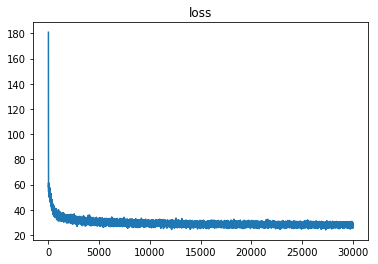

In [15]:
plt.figure()
plt.plot(vloss)
plt.title('loss')
print(np.shape(vloss))

(30000, 64)


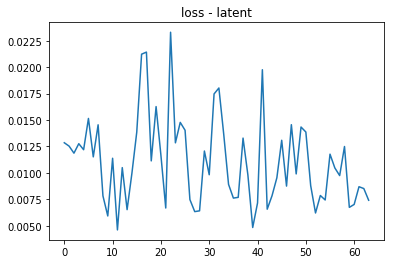

In [16]:
plt.figure()
plt.plot(vll[:][1])
plt.title('loss - latent')
print(np.shape(vll))

### Generating new data
The most awesome part is that we are now able to create new characters. To this end, we simply sample values from a unit normal distribution and feed them to our decoder. Most of the created characters look just like they've been written by humans.

In [17]:
x1 = np.random.normal(0, 1, n_latent)
print(x1)

[ 0.02112636  0.43540979 -0.17198946 -1.03745878  1.57083942 -1.81807175
  1.7037211   0.31264264  0.12725004 -0.55804877 -0.97138376  0.3119509
  1.12791394  1.48420328 -0.03679421 -0.03196217]


(array([0.28394629, 0.        , 0.        , 0.56789257, 0.        ,
        0.28394629, 0.        , 0.28394629, 1.13578515, 0.56789257,
        0.28394629, 0.        , 0.        , 0.28394629, 0.        ,
        0.85183886]),
 array([-1.81807175, -1.59795969, -1.37784764, -1.15773559, -0.93762354,
        -0.71751148, -0.49739943, -0.27728738, -0.05717532,  0.16293673,
         0.38304878,  0.60316083,  0.82327289,  1.04338494,  1.26349699,
         1.48360904,  1.7037211 ]),
 <a list of 16 Patch objects>)

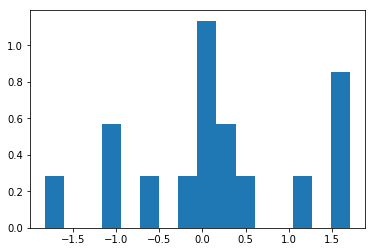

In [18]:
n_bins = n_latent
plt.hist(x1, n_bins, normed=1, histtype='bar')

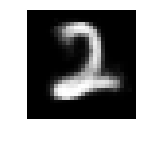

In [19]:
img = sess.run(dec, feed_dict = {sampled: [x1], keep_prob: 1.0})
img = np.reshape(img, [28, 28])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [20]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
print(np.shape(randoms))

(10, 16)


In [21]:
import os
if not os.path.exists('out'):
    os.makedirs('out')

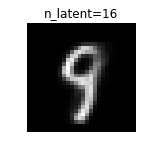

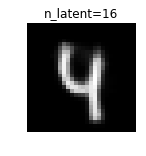

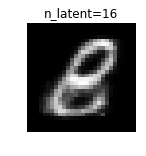

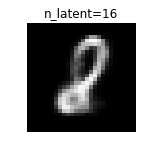

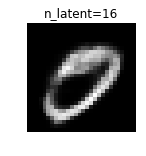

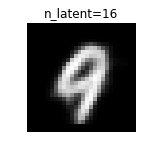

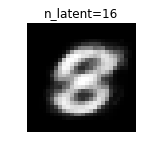

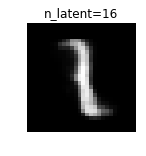

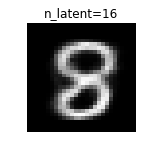

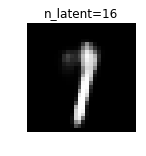

In [22]:
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
i=0
for img in imgs:
    f1 = plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.title('n_latent={}'.format(n_latent))
    plt.imshow(img, cmap='gray')
    plt.savefig('out/l{}_{}.png'.format(n_latent, i))
    i = i+1

### Just for test

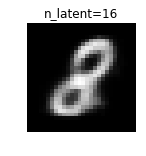

In [23]:
#x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, 0.7, -0.5, -2.5]
x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, -0.7, -0.5, -2.5, 1.2, 1.8, -0.1, 0.7, -0.2, 0.7, -0.5, 0.0]
img = sess.run(dec, feed_dict = {sampled:[x2], keep_prob: 1.0})
img = np.reshape(img, [28, 28])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.title('n_latent={}'.format(n_latent))
plt.imshow(img, cmap='gray')

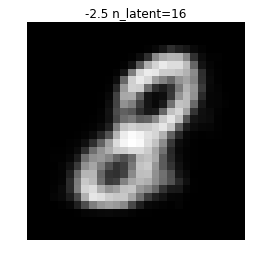

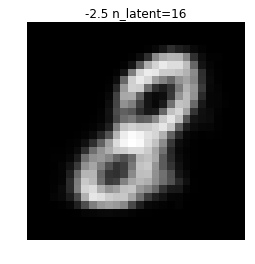

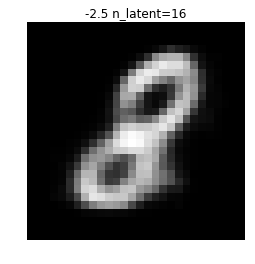

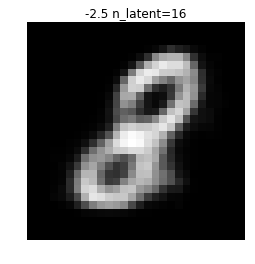

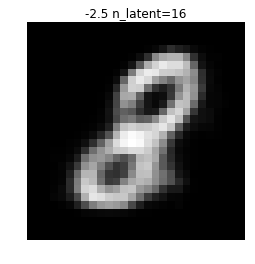

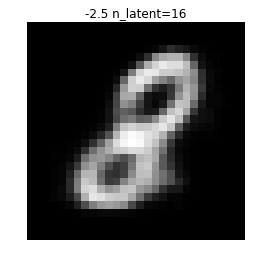

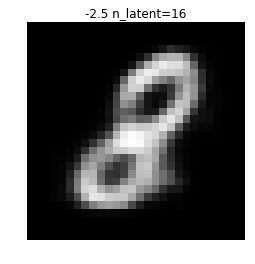

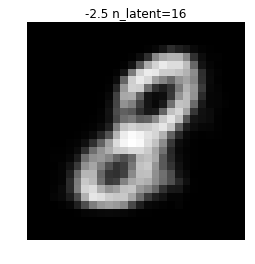

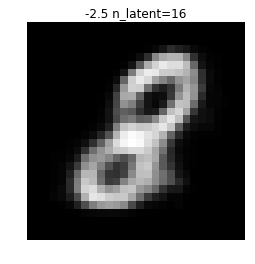

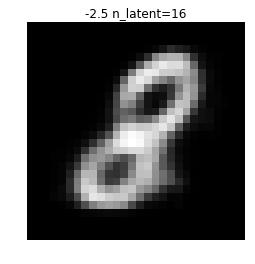

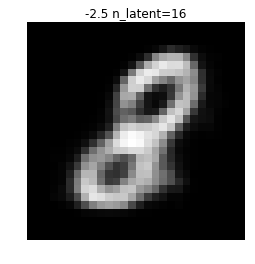

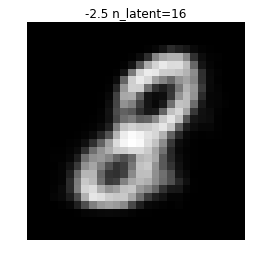

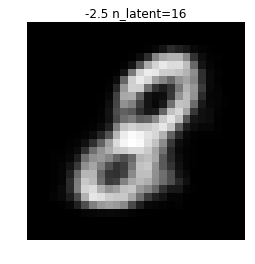

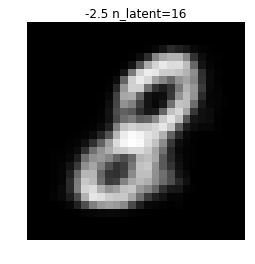

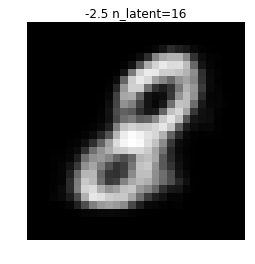

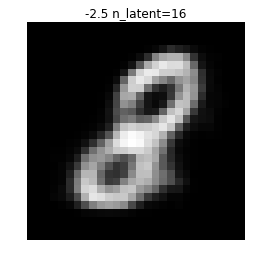

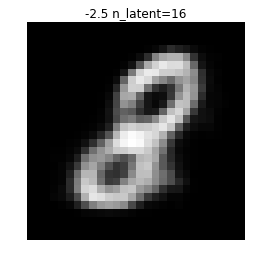

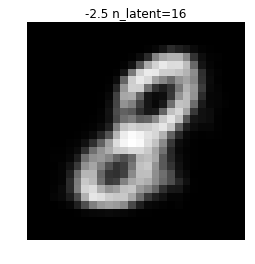

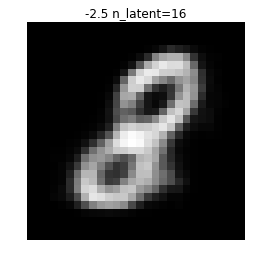

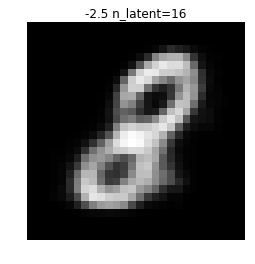

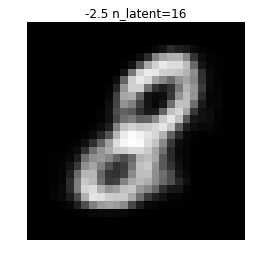

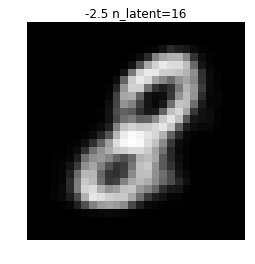

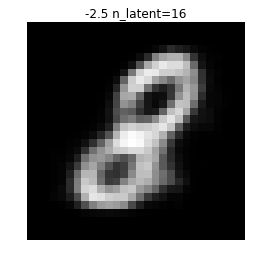

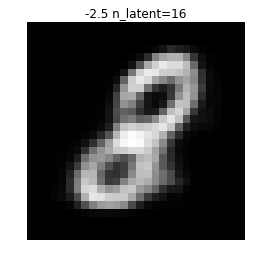

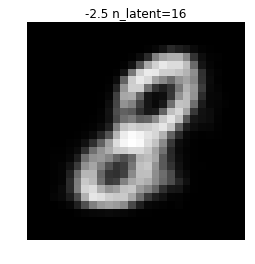

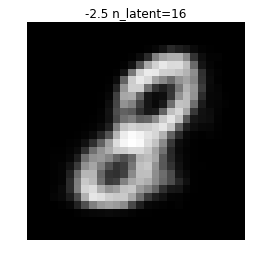

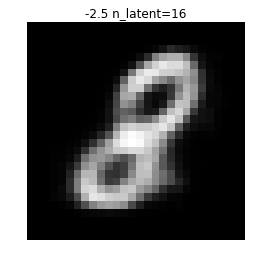

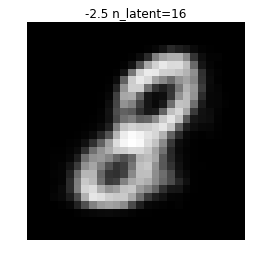

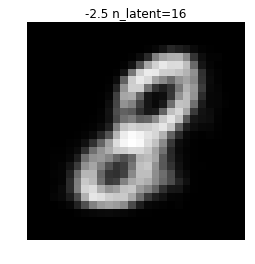

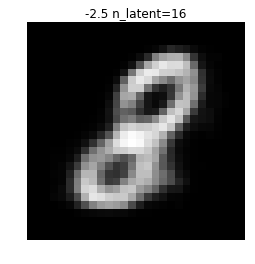

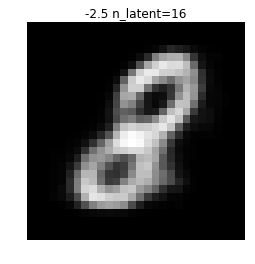

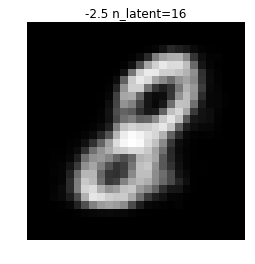

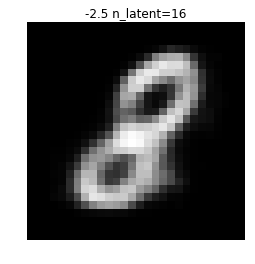

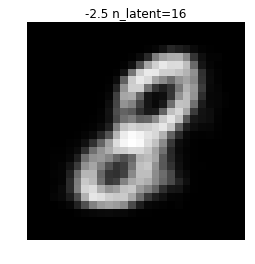

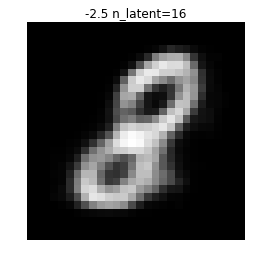

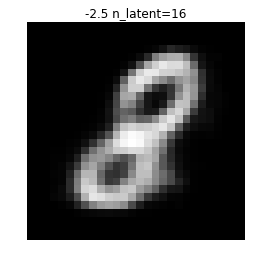

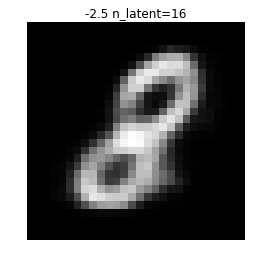

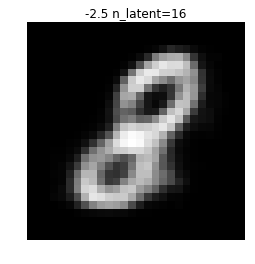

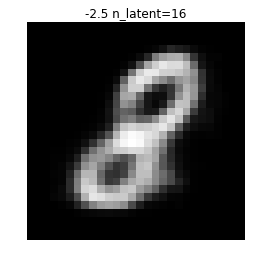

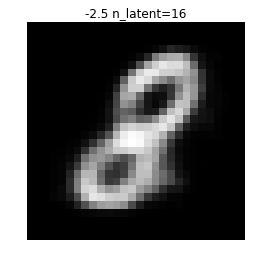

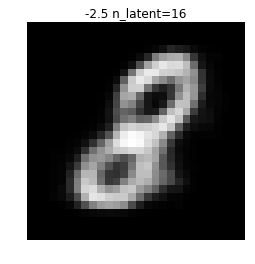

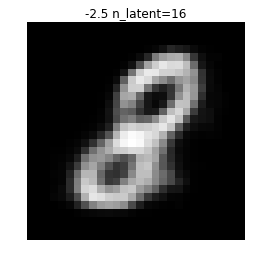

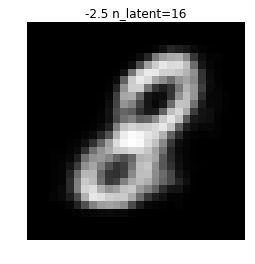

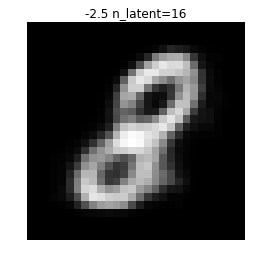

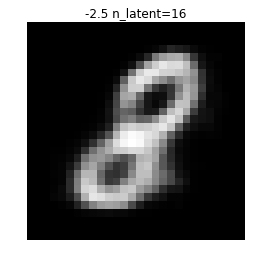

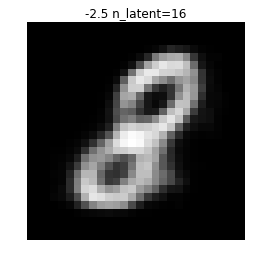

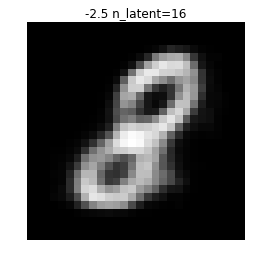

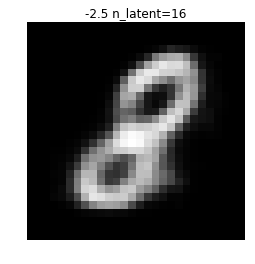

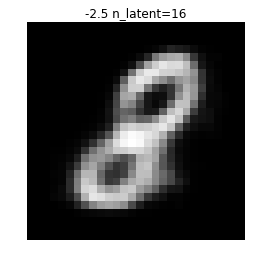

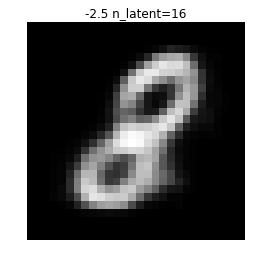

In [24]:
#x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, 0.7, -0.5, -2.5]
x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, -0.7, -0.5, -2.5, 1.2, 1.8, -0.1, 0.7, -0.2, 0.7, -0.5, 0.0]
for i in range(50):
    x2[1] = x2[1]+0.1
    img = sess.run(dec, feed_dict = {sampled:[x2], keep_prob: 1.0})
    img = np.reshape(img, [28, 28])
    plt.figure()
    plt.axis('off')
    plt.title('{} n_latent={}'.format(round(x2[7], 2), n_latent))
    plt.imshow(img, cmap='gray')
    plt.savefig('out/test_l{}_{}.png'.format(n_latent, i))

### References
* https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
* https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb